# Import packages

In [17]:
from array import array
import itertools
import time
import math

import sys
sys.path.insert(0,'/usr/common/software/rootpy/')
import root_numpy
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

#import astroML.plotting as aml
#import iminuit
import pandas as pd
import root_pandas as rpd
from root_pandas import read_root
import ROOT
from ROOT import TH1D
from ROOT import SetOwnership
from matplotlib.ticker import NullFormatter
from ROOT import TLatex

# File

In [18]:
#RootFile = 'InputData/13e_4L_SE_GMB_Ratio.root'
#RootFile = 'InputData/13d_4L_0GeVTrack_paired_SE_Correlation_GMB_Ratio.root'

#RootFile = 'InputData/13def_SE_GMB_Ratio_Old_Norm.root'
#RootFile = 'InputData/13def_SE_GMB_Ratio.root'
#RootFile = 'InputData/13def_4L_SE_Correlation_GMB_Ratio_15_20.root'

#RootFile = 'InputData/18b10a_calo_pthat1to2_SE_Correlation.root'
#RootFile = 'InputData/18b10a_calo_pthat4_SE_Correlation.root'
#RootFile = 'InputData/18b10a_calo_pthat1to2_0GeVTrack_paired_0GeVTracks_Correlation_0_to_10.root'
#RootFile = 'InputData/18b10a_calo_pthat1to2_GMB_0GeVTracks.root'
#RootFile = 'InputData/18b10a_calo_pthat1to2_SE_Correlation_GMB_Ratio.root'

#RootFile = 'InputData/17q_GMB_Correlation_lzt_0GeVTracks.root'
#RootFile = 'InputData/17q_0GeVTrack_paired_SE_Correlation.root'
#RootFile = 'InputData/17q_0GeVTrack_paired_SE_Correlation_GMB_Ratio.root'
#RootFile = 'InputData/17q_SE_Correlation_GMB_Ratio.root'
#RootFile = 'InputData/17q_17p_GMB_Correlation.root'
#RootFile = 'InputData/18b10a_pthat_1_2_SE_Correlation.root'
#RootFile = 'InputData/13def_4L_SE_L0_Correlation_GMB_Ratio.root'
RootFile = 'InputData/17q_SE_NN_Correlation_GMB_Ratio.root'
#RootFile = 'InputData/17q_SE_NN_Correlation_GMB_Ratio.root'
#RootFile = 'InputData/17q_0GeVTrack_paired_SE_L0_Correlation_GMB_Ratio.root'
#RootFile = 'InputData/18b10a_pthat_1_2_SE_L0_Correlation_GMB_Ratio.root'


# Define Bins and Purity


In [19]:
#FIXME: Read from Corr_config.yaml
#zTbins = [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2]
zTbins = [0.05, 0.07670637, 0.11767734, 0.18053204, 0.27695915, 0.42489062, 0.65183634, 1]
pTbins = [0,0,12, 15]
purity = [1, 1, 0.352546]
#purity = [1,1,0.271083]
print purity[2]
#purity = [1, 1, 0.55]
#pTbins = [0,0,15,20]

0.352546


# Define Errors

In [20]:
p_error_sys = 0.06
#p_error_stat = 
eff_error = 0.05

# Prefix

In [21]:
#prefix = '13def'
#prefix = '18b10a'
#prefix = '18b10a'
#prefix = '18b10a_15_20'
#prefix = '13def_15_20'
#prefix = 'p-Pb'
#prefix = 'P-bp'
prefix = 'pp'
#prefix = 'pp_mix'
#prefix = 'pp_Same_Only'

## Plot Titles

In [22]:
def Plot1D (histo, ptbin, ztbin,DNN_Bool):
    #histo.SetTitle("#gamma - h : p_{T}^{Clus.}(%1.1f-%1.1f),  z_{T}(%1.2f-%1.2f)"
    #               %(pTbins[ptbin],pTbins[ptbin+1],zTbins[ztbin],zTbins[ztbin+1]))
    
    histo.SetTitle("#gamma - h: p_{T}^{Clus.}(%1.1f-%1.1f),  z_{T}(%1.2f-%1.2f)"%(pTbins[ptbin],pTbins[ptbin+1],zTbins[ztbin],zTbins[ztbin+1]))
    
    histo.GetXaxis().SetTitle("#Delta#phi")
    histo.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{d^{2}N}{d#phid#eta}")
    #histo.GetYaxis().SetTitle("#frac{d^{2}N}{d#phid#eta}")
    #histo.GetYaxis().SetTitleSize(0.035)
    #histo.GetYaxis().SetTitleOffset(1)
    histo.GetXaxis().CenterTitle(1)
    histo.GetXaxis().SetTitleOffset(0.6)
    histo.GetXaxis().SetTitleSize(0.06)
    
    histo.GetYaxis().SetTitleSize(0.05)
    histo.GetYaxis().SetTitleOffset(1.5)
    
    ROOT.gStyle.SetOptStat("")
    ROOT.gStyle.SetPalette(ROOT.kViridis)
    histo.SetLineWidth(1)
    histo.SetLineColor(4)
    histo.SetMarkerColor(4)
    if not(DNN_Bool):
        histo.SetLineColor(2)
        histo.SetMarkerColor(2)

# Label

In [23]:
def DrawLabel2(Signal_DNN = True):
    latex = TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.05)
    if (Signal_DNN == "inclusive"):
        #latex.SetTextSize(0.04)
        if (prefix=="13def" or prefix =="13def_15_20"):
            latex.DrawLatex(0.31,0.83, "#color[1]{p-Pb + Pb-p Inclusive}")
        else:
            latex.DrawLatex(0.31,0.83, "#color[1]{%s Inclusive}"%(prefix))
            
    elif (Signal_DNN):
        if (prefix=="13def" or prefix =="13def_15_20"):
            latex.DrawLatex(0.31,0.83, "#color[4]{p-Pb + Pb-p Signal Region}")
        else:
            latex.DrawLatex(0.31,0.83, "#color[4]{%s Signal}"%(prefix))
            
    else:
        if (prefix=="13def" or prefix =="13def_15_20"):
            latex.DrawLatex(0.31,0.83, "#color[2]{p-Pb + Pb-p Bkgd Region}")
        else:
            latex.DrawLatex(0.31,0.83, "#color[2]{%s Bkgnd}"%(prefix))

<sup> **Note** Scaling is done cell by cell (despite Axis title here) for accurate subtraction<sup>

# ZYAM

In [24]:
def Subtract_ZYAM (PhiProjection):
    nbins = PhiProjection.GetSize()-2 #underflow,overflow

    #zyam = PhiProjection.Integral(3,4)/2
    Z_min = (PhiProjection.GetXaxis().FindBin(0.9)) #avoid bias of isolation in this region  
    Z_max = (PhiProjection.GetXaxis().FindBin(1.5)-1)
    Z_N = Z_max-Z_min+1
    zyam = PhiProjection.Integral(Z_min,Z_max)/(Z_N)

    for i in range(nbins+1):
            y = PhiProjection.GetBinContent(i)
            y_error = PhiProjection.GetBinError(i)
            new_y = y-zyam
            PhiProjection.SetBinContent(i,new_y)
            #assumes 0 error in ZYAM
            new_y_error = y_error
            PhiProjection.SetBinError(i,new_y_error)

In [71]:
def ZYAM_Line(hsig):
    Z_min = (hsig.GetXaxis().FindBin(0.9)) #avoid bias of isolation in this region  
    Z_max = (hsig.GetXaxis().FindBin(1.5)-1)
    Z_N = Z_max-Z_min+1
    zyam_value = hsig.Integral(Z_min,Z_max)/(Z_N)
    
    #Errors
    Z_Error = 0
    for NError in range(Z_min,Z_max+1):
        Z_Error += (hsig.GetBinError(NError))**2
    Z_Error = math.sqrt(Z_Error)
    
    #LE TGraph
    NBins = hsig.GetSize()-2
    ZYAM = ROOT.TGraphErrors()
    for NBin in range(0,NBins+1):
        ZYAM.SetPoint(NBin,(NBin*math.pi/NBins),zyam_value)
        ZYAM.SetPointError(NBin,0,Z_Error)
    
    #print "zyam line value: ",zyam_value 
    ZYAM.SetFillColorAlpha(7, 0.6);
    SetOwnership(ZYAM, 0)
    
    #print Z_min, Z_max, Z_N
    #ZYAM = ROOT.TLine(0,zyam_value,math.pi,zyam_value)
    #ZYAM.SetLineColorAlpha(7, 0.9)
    #ZYAM.SetLineWidth(5)
    #SetOwnership(ZYAM, 0)
    
    return ZYAM

## N Triggers

In [72]:
def Get_NTriggers(filename,prfx,ipt, Signal_DNN=True): 
    file = ROOT.TFile(filename)
    if (Signal_DNN == "inclusive"):
        ntrig_histo = file.Get('N_Triggers_pT%1.0f_%1.0f' %(pTbins[ipt],pTbins[ipt+1]))
    else:
        DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN))
        ntrig_histo = file.Get('N_DNN%i_Triggers_pT%1.0f_%1.0f' %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1]))
    NTriggers = 1
    if not(ntrig_histo == None):
        if (prfx =="18b10a"):
            NTriggers = ntrig_histo.Integral(0,-1)
        else:
            NTriggers = ntrig_histo.GetEntries()
    file.Close()
    return NTriggers

## Large $\eta$

In [120]:
def GetLEProj(filename, ipt, izt, Signal_DNN=True):
    file = ROOT.TFile(filename)
    
    DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)
    
    if (Signal_DNN == "inclusive"):
        histo2D = file.Get('Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                        %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        
        LE_Projection = histo2D.ProjectionX('Inclusive_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                      %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        100*zTbins[izt+1]),Eta_Axis.FindBin(-0.6),Eta_Axis.FindBin(0.6))
                                        #10*zTbins[izt+1]),5,11)
        LE_Projection_pos = histo2D.ProjectionX('PosEta_inclusive_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                    100*zTbins[izt+1]),Eta_Axis.FindBin(0.8),Eta_Axis.FindBin(1.4))
  
        ntriggers = Get_NTriggers(filename,prefix, ipt, Signal_DNN)  
        if not(ntriggers == None):
            LE_Projection.Scale(1.0/ntriggers) #per trigger yield
    else:
        #DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)
        
        histo2D_1 = file.Get('DNN1_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                             %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        histo2D_2 = file.Get('DNN2_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                             %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
#         histo2D_1 = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
#                             %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
#         histo2D_2 = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
#                             %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
      
        
        #Project
        Eta_Axis = histo2D_1.GetYaxis()
        
        #ntriggers_DNN1 = Get_NTriggers(filename,prefix, ipt, Signal_DNN) 
        
        ntriggers_DNN1 = Get_NTriggers(filename,prefix, ipt, True)
        ntriggers_DNN2 = Get_NTriggers(filename,prefix, ipt, False)       
    
        LE_Projection = histo2D_1.ProjectionX('NegEta_DNN1_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],
                                    10*zTbins[izt+1]),Eta_Axis.FindBin(-1.4),Eta_Axis.FindBin(-0.8))
        
        LE_Projection_pos = histo2D_1.ProjectionX('PosEta_DNN1_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],
                                    10*zTbins[izt+1]),Eta_Axis.FindBin(0.8),Eta_Axis.FindBin(1.4))    
        
        LE_Projection_DNN2 = histo2D_2.ProjectionX('NegEta2_DNN2_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],
                                    10*zTbins[izt+1]),Eta_Axis.FindBin(-1.4),Eta_Axis.FindBin(-0.8))

        LE_Projection_DNN2_pos = histo2D_2.ProjectionX('PosEta2_DNN2_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],
                                    10*zTbins[izt+1]),Eta_Axis.FindBin(0.8),Eta_Axis.FindBin(1.4))
        
        LE_Projection.Scale(1.0/ntriggers_DNN1)
        LE_Projection_pos.Scale(1.0/ntriggers_DNN1)
        
        LE_Projection_DNN2.Scale(1.0/ntriggers_DNN2)
        LE_Projection_DNN2_pos.Scale(1.0/ntriggers_DNN2)
        
        
        LE_Projection.Add(LE_Projection_DNN2,1)
        LE_Projection.Scale(0.5)
        
        LE_Projection_pos.Add(LE_Projection_DNN2_pos,1)
        LE_Projection_pos.Scale(0.5)
        
    
    #Add,scale 
    LE_Projection.SetDirectory(0)
    LE_Projection.Add(LE_Projection_pos,1)
    LE_Projection.Rebin(2)
    LE_Projection.Scale(1.0/1.2) #scale by eta region
    Plot1D(LE_Projection,ipt,izt,Signal_DNN)
    LE_Projection.SetMarkerStyle(25)
    LE_Projection.SetLineColorAlpha(1,0.1)
    #LE_PhiProjection.SetMarkerSize(3)
    LE_Projection.SetMarkerColor(1)
        
    #Legend
    #legend = ROOT.TLegend(0.64,0.78,0.89,0.88)
    legend = ROOT.TLegend(0.3,0.69,0.6,0.80)
    legend.SetBorderSize(0)
    LE_Projection.SetLineColorAlpha(1,0.9) #8 for light green
    #legend.AddEntry(LE_PhiProjection, "0.8 <|#eta| < 1.4","p")
    SetOwnership(legend, 0)
    file.Close()
    return LE_Projection,legend

#### Simplify above with calls to getPhiProjection()

In [121]:
def GetLE_Line(LE_Proj):
    LE_min = (LE_Proj.GetXaxis().FindBin(0.4)) #avoid bias of isolation in this region  
    LE_max = (LE_Proj.GetXaxis().FindBin(1.4))
    LE_N = LE_max-LE_min+1
    LE_value = LE_Proj.Integral(LE_min,LE_max)/(LE_N)
    #print LE_value
    
    #Errors
    Temp_Error = 0
    for NError in range(LE_min,LE_max+1):
        Temp_Error += (LE_Proj.GetBinError(NError))**2
    #print Temp_Error
    
    Temp_Error = math.sqrt(Temp_Error)
    LE_Error = Temp_Error/math.sqrt(LE_max-LE_min+1)
    #LE_Error = LE_Error/math.sqrt(10000)
    
    #LE TGraph
    NBins = LE_Proj.GetSize()-2
    LE_Line = ROOT.TGraphErrors()
    for NBin in range(0,NBins+1):
        LE_Line.SetPoint(NBin,(NBin*math.pi/NBins),LE_value)
        LE_Line.SetPointError(NBin,0,LE_Error)
    
    print "LE Line Value: ","%1.3f"%(LE_value)," +/- ","%1.3f"%(LE_Error)
    
    LE_Line.SetFillColorAlpha(1, 0.2);
    #LE_Line = ROOT.TLine(0,LE_value,math.pi,LE_value)
    #LE_Line.SetLineColorAlpha(1, 0.9)
    #LE_Line.SetLineWidth(5)
    SetOwnership(LE_Line, 0)
    #legend
    legend = ROOT.TLegend(0.74,0.78,0.89,0.88)
    legend.AddEntry(LE_Line, "0.8 <|#eta| < 1.4","l")
    SetOwnership(legend, 0)
    return LE_Line,legend

In [122]:
def GetLE_Val(LE_Proj):
    LE_min = (LE_Proj.GetXaxis().FindBin(0.4)) #avoid bias of isolation in this region  
    LE_max = (LE_Proj.GetXaxis().FindBin(1.4))
    LE_N = LE_max-LE_min+1
    LE_value = LE_Proj.Integral(LE_min,LE_max)/(LE_N)
    return LE_value

In [123]:
def Subtract_LE(PhiProjection,LE_Proj,DoSys=False):
    nbins = PhiProjection.GetSize()-2 #underflow,overflow    

    LE_min = (LE_Proj.GetXaxis().FindBin(0.4)) #avoid bias of isolation in this region  
    LE_max = (LE_Proj.GetXaxis().FindBin(1.4))
    LE_N = LE_max-LE_min+1
    LE = LE_Proj.Integral(LE_min,LE_max)/(LE_N)
    
    LE_Error = 0
    for NError in range(LE_min,LE_max):
        LE_Error += (LE_Proj.GetBinError(NError))**2
    #print "Quad Sum of Errors:",LE_Error
    LE_Error = math.sqrt(LE_Error)
    LE_Error = LE_Error/(LE_N)
    #print "SQRT N:",math.sqrt(LE_N)
    #print "After SQRT and /SQRT(N):",LE_Error

    #print "LE Value: ",LE," +/- ",LE_Error
    #print "LE Error:",LE_Error
    sumerror=0
    for i in range(nbins+1):
            y = PhiProjection.GetBinContent(i)
            y_error = PhiProjection.GetBinError(i)
            new_y = y-LE
            PhiProjection.SetBinContent(i,new_y)
            if (DoSys):
                #new_y_error = math.sqrt(LE_Error**2) #Propagate the systematic by itself
                new_y_error = 0
            else:
                new_y_error = y_error    
            PhiProjection.SetBinError(i,new_y_error)

    #print math.sqrt(sumerror)

#### Check

In [124]:
#LE,legend = GetLEProj(RootFile, 0, 0, True)
#cav = ROOT.TCanvas("cav","cav", 500,160)
#LE.Draw()
#legend.Draw()
#cav.Draw()
#GetLE_Line(LE)

<sup>**NOTE**: The DNN corresponding to one photon is reflected in the naming scheme of histograms, where DNN1_Histo is signal (the same here) but background (DNN corresponding to 2 photons) is DNN2_Histo. Here, the DNN variable is a boolian corresponding to *true for signal*, *false for background* (not signal)<sup>

# Get Phi Projection

In [125]:
def GetPhiProj(filename,prfx,ipt, izt, Signal_DNN=True, doZYAM=True,DoSys=False):
    file = ROOT.TFile(filename)

    if (DoSys):
        SysE = "_Stat+Sys"
    else:
        SysE = ""
    
    if (Signal_DNN == "inclusive"):
        histo2D = file.Get('Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                        %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        PhiProjection = histo2D.ProjectionX('Inclusive_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f%s' 
                                      %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        100*zTbins[izt+1],SysE),Eta_Axis.FindBin(-0.6),Eta_Axis.FindBin(0.6))
                                        #10*zTbins[izt+1]),5,11)
    
    else:
        DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)
        histo2D = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                            %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        PhiProjection = histo2D.ProjectionX('DNN%i_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f%s' 
                                      %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        100*zTbins[izt+1],SysE),Eta_Axis.FindBin(-0.6),Eta_Axis.FindBin(0.6))
                                        #10*zTbins[izt+1]),5,11)
    
    PhiProjection.SetDirectory(0)
    PhiProjection.Rebin(2)
    PhiProjection.Scale(1.0/1.2) #scale by eta region
    #PhiProjection.SetMarkerStyle(20)
    
    ntriggers = Get_NTriggers(filename,prfx,ipt, Signal_DNN)
    if not(ntriggers == None):
        PhiProjection.Scale(1.0/ntriggers) #per trigger yield
        
        
    Plot1D(PhiProjection,ipt,izt,Signal_DNN)    
    if(doZYAM):
        LE_Proj,legend = GetLEProj(filename, ipt, izt, Signal_DNN)
        Subtract_LE(PhiProjection,LE_Proj,DoSys)#Stat+Sys Bool (True, False = Just Stat.)
        #Subtract_ZYAM(PhiProjection)
    
    file.Close()
    return PhiProjection

In [126]:
for ztbin in range(6):
    GetPhiProj(RootFile,prefix,2,ztbin,True,True,True) #Signal=Yes,ZYAM=No,SysError=No.

<sup>**NOTE**: SetDirectory(0) needed because when a file in root is called, the gDirectory is changed to point to it. The creation of a histogram (PhiProjection) is associated to that file and contains a local reference, which is destroyed when the function exits. Thus, returns 'None' unless the Directory (reference) is changed. Root is annoying.</sup>

In [135]:
for ipt in range (3):
    if (ipt > 0): continue
    ipt = ipt+2
    for izt in range (6):
        hsig =  GetPhiProj(RootFile,prefix,ipt,izt,True,False,False)
        hbkg = GetPhiProj(RootFile,prefix,ipt,izt,False,False,False)
        
        sig_line = ZYAM_Line(hsig)
        bkg_line = ZYAM_Line(hbkg)
        NBins = hsig.GetSize()-2
        
        z_sig = sig_line.GetY()
        z_bkg = bkg_line.GetY()
        
        ztemp = 0
        ztemp += (z_sig[1] + z_bkg[1])/2
        z_sig_error = sig_line.GetErrorY(1)
        z_bkg_error = bkg_line.GetErrorY(1)
        z_error = math.sqrt(z_sig_error**2 + z_bkg_error**2)/2
        #print "%1.4f"%(z_error)
        print "%1.3f"%((z_bkg[1]+z_sig[1])/2)
        #print ztemp, z_error

0.194
0.126
0.065
0.025
0.009
0.003


### Side By Side

In [128]:
def SideSide(Region):
        Uncorr = True
        DoSub = False
        DoSys = False
        ptbin = 0
        ptbin = ptbin+2;
        canvases = ROOT.TCanvas("Canv_Side_Side_%i"%(ptbin),"Canv_Side_Side_%i"%(ptbin),1100,700)
        #canvases = ROOT.TCanvas("Canv_Side_Side_%i"%(ptbin),"Canv_Side_Side_%i"%(ptbin),10000,8000)
        
        if (Region=="regions"):
            #canvases.Divide(2,1)
            canvases.Divide(4,3)
        elif(Region=="inclusive"):
            canvases.Divide(3,2)
            
        for ztbin in range(6):
                
            if (Region=="regions"):              
            #grab
                hsig = GetPhiProj(RootFile,prefix,ptbin,ztbin,True,DoSub,False) #[DNN],[Subtraction Bool] [DoSysErr]
                hbkg = GetPhiProj(RootFile,prefix,ptbin,ztbin,False,DoSub,False)
                ymax = 1.2*max(hsig.GetMaximum(),hbkg.GetMaximum())
                
                if (DoSys):
                    hsig_sys = GetPhiProj(RootFile,prefix,ptbin,ztbin,True,DoSub,True)
                    hbkg_sys = GetPhiProj(RootFile,prefix,ptbin,ztbin,False,DoSub,True)
                
                if not(DoSub):
                    hsig.GetYaxis().SetRangeUser(0,ymax)
                    hbkg.GetYaxis().SetRangeUser(0,ymax)  
                if (DoSub):
                    ymin = 1.4*min(hsig.GetMinimum(),hbkg.GetMinimum())
                    hsig.GetYaxis().SetRangeUser(ymin,ymax)
                    hbkg.GetYaxis().SetRangeUser(ymin,ymax)    
                
                canvases.cd(ztbin*2+1)
                ROOT.gPad.SetLeftMargin(0.18)
                ROOT.gPad.SetRightMargin(0.0)
                #canvases.cd(ztbin+1)
                Sig_ZYAM= ZYAM_Line(hsig) #Change to UnCorr_Line, swith to high rapidity
                LE_sig,legend = GetLEProj(RootFile, ptbin, ztbin,True)
                LE_Line,temp = GetLE_Line(LE_sig)
                
                if (DoSys):
                    hsig_sys.SetLineColor(1)
                    hsig_sys.Draw()
                    hsig.Draw("sameE1")
                else:    
                    hsig.Draw()  
                DrawLabel2(True)
                if(Uncorr):
                    Sig_ZYAM.Draw("same3")
                    LE_Line.Draw("same3")
                    hsig.Draw("same")
                    LE_sig.SetLineWidth(1)
                    LE_sig.Draw("same")
                    #legend.AddEntry(hsig,"High DNN","p")
                    legend.AddEntry(LE_sig, "0.8 <|#Delta#eta| < 1.4","p")
                    legend.AddEntry(LE_Line, "#LT Large #Delta#eta #GT","f")
                    legend.AddEntry(Sig_ZYAM, "ZYAM","f")
                    legend.Draw("same")

            if (Region=="inclusive"):
                    hsig = GetPhiProj(RootFile,prefix,ptbin,ztbin,"inclusive",False,False)
                    ymax = 1.2*hsig.GetMaximum()
                    hsig.GetYaxis().SetRangeUser(0,ymax)
                    canvases.cd(ztbin+1) 
                    ROOT.gPad.SetLeftMargin(0.18)
                    ROOT.gPad.SetRightMargin(0.0)
                    hsig.Draw()  
                    DrawLabel2("inclusive")
                    
                
            #Background
            if (Region=="regions"): 
                canvases.cd(ztbin*2+2)
                ROOT.gPad.SetLeftMargin(0.18)
                ROOT.gPad.SetRightMargin(0.0)
                BKG_ZYAM = ZYAM_Line(hbkg)
                LE_bkg,legend = GetLEProj(RootFile, ptbin, ztbin, False)
                LE_bkg_Line,temp = GetLE_Line(LE_bkg)
                
                if (DoSys):
                    hbkg_sys.SetLineColor(1)
                    hbkg_sys.Draw()
                    hbkg.Draw("sameE1")
                else:
                    hbkg.Draw()
                DrawLabel2(False)
                if (Uncorr):
                    BKG_ZYAM.Draw("same3")
                    LE_bkg_Line.Draw("same3")
                    hbkg.Draw("same")
                    LE_bkg.SetLineWidth(1)
                    LE_bkg.Draw("same")
                    #legend.AddEntry(hbkg,"Low DNN","p")
                    legend.AddEntry(LE_bkg, "0.8 <|#Delta#eta| < 1.4","p")
                    legend.AddEntry(LE_bkg_Line, "#LT Large #Delta#eta #GT","f")
                    legend.AddEntry(BKG_ZYAM, "ZYAM","f")
                    legend.Draw("same")
                #canvases.SaveAs("pics/%s_Phi_2DNN_zT__%1.0f_%1.0f.pdf"%(prefix,100*zTbins[ztbin],100*zTbins[ztbin+1]))
        canvases.Update()
        canvases.Draw()
        if (Region=="inclusive"):
            canvases.SaveAs("pics/%s_Inclusive_Phi.pdf"%(prefix))
            canvases.SaveAs("pics/%s_Inclusive_Phi.png"%(prefix))
        if (Region=="regions"):
            if(Uncorr):
                canvases.SaveAs("pics/%s_Phi_2DNN_Uncorr.pdf"%(prefix))
                canvases.SaveAs("pics/%s_Phi_2DNN_Uncorr.png"%(prefix))
            else:
                canvases.SaveAs("pics/%s_Phi_2DNN.pdf"%(prefix))
                canvases.SaveAs("pics/%s_Phi_2DNN.png"%(prefix))
        return canvases
#myText(.2,.2,"hello_%i"%number,1) ‹›

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: Canv_Side_Side_2


LE Line Value:  0.180  +/-  0.004
LE Line Value:  0.180  +/-  0.004
LE Line Value:  0.122  +/-  0.003
LE Line Value:  0.122  +/-  0.003
LE Line Value:  0.061  +/-  0.002
LE Line Value:  0.061  +/-  0.002
LE Line Value:  0.024  +/-  0.002
LE Line Value:  0.024  +/-  0.002
LE Line Value:  0.007  +/-  0.001
LE Line Value:  0.007  +/-  0.001
LE Line Value:  0.004  +/-  0.001
LE Line Value:  0.004  +/-  0.001


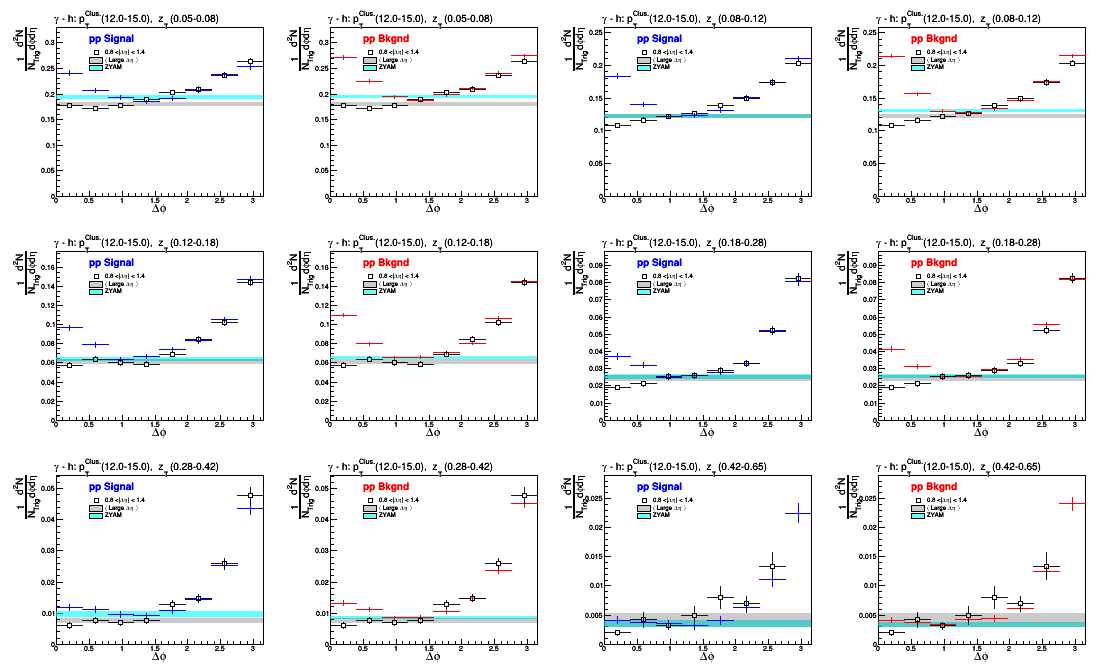

<ROOT.TCanvas object ("Canv_Side_Side_2") at 0x7ebb530>

Info in <TCanvas::Print>: pdf file pics/pp_Phi_2DNN_Uncorr.pdf has been created
Info in <TCanvas::Print>: png file pics/pp_Phi_2DNN_Uncorr.png has been created


In [129]:
SideSide("regions")
#SideSide("inclusive")

In [37]:
def DrawLabel(NTriggers,ptbin):
    latex = TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.03)
    latex.DrawLatex(0.6,0.81, "#color[2]{purity = %1.2f}"%(purity[ptbin]))
    #latex.DrawLatex(0.12,0.85, "#color[2]{no purity scaling}")
    latex.DrawLatex(0.22,0.81, "#color[4]{%1.0f Triggers}"%(NTriggers))

In [38]:
def DrawLabel3(NTriggers,DoSub=True):
    latex = TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.03)
    if (DoSub):
        latex.SetTextSize(0.04)
        #latex.DrawLatex(0.12,0.85, "#color[4]{%1.0f Triggers}"%(NTriggers))
        if (prefix=="13def"):
            latex.DrawLatex(0.22,0.85, "#color[4]{pPb+Pbp After Subtraction}")
        else:
            latex.DrawLatex(0.22,0.85, "#color[4]{%s After Subtraction}"%(prefix))
    else: 
        if (prefix=="13def"):
            latex.DrawLatex(0.22,0.85, "#color[4]{p-Pb+Pb-p Signal Region}")
            latex.DrawLatex(0.6,0.85, "#color[2]{(1-p)Bkgnd Region}")
        else:
            latex.DrawLatex(0.22,0.85, "#color[4]{%s Signal Region}"%(prefix))
            latex.DrawLatex(0.6,0.85, "#color[2]{%s (1-p)Bkgnd Region}"%(prefix))

# Purity Scaling + Subtraction

#### Subtraction: $C_{S} = \frac{C_{SR} - (1-p) C_{BR}}{p}$

In [39]:
def GetBKGsubtracted(filename,prfx,ptbin, ztbin, doZYAM=True, doSubtraction=True, DoSys=False):
    Signal = GetPhiProj(filename,prefix,ptbin,ztbin,True,doZYAM,DoSys) #High DNN (True)
    Background = GetPhiProj(filename,prefix,ptbin,ztbin,False,doZYAM,DoSys) #Low DNN (False)
    N1 = Get_NTriggers(filename,prfx,ptbin, True)
    N2 = Get_NTriggers(filename,prfx,ptbin, False)
    
    LE_Proj_Sig,legend = GetLEProj(filename, ptbin, ztbin, True)
    LE_Proj_Bkg,legend_bkg = GetLEProj(filename, ptbin, ztbin, False)
    
    LE_Sig = GetLE_Val(LE_Proj_Sig)
    LE_Bkg = GetLE_Val(LE_Proj_Bkg)
    
    nbins = Signal.GetSize()-2
    p_error = math.sqrt(0.028**2 + 0.06**2)

    if (doSubtraction):
        
        if (DoSys):
            #print "GetBkgSubtracted"    
            for i in range(nbins+1):
                y_s = Signal.GetBinContent(i)
                y_s_new = y_s*(1/purity[ptbin])
                y_s_error = Signal.GetBinError(i) 
                y_s_new_error = (abs(y_s_new))*math.sqrt((y_s_error/y_s)**2 + (p_error/purity[ptbin])**2)# + (0.06 / 0.75)**2)
        
                Signal.SetBinError(i,y_s_new_error)
                Signal.SetBinContent(i,y_s_new)
                
                y_b = Background.GetBinContent(i)
                y_b_new = y_b*((1-purity[ptbin])/purity[ptbin])
                y_b_error = Background.GetBinError(i) #JUST UE Error
                y_b_new_error = (abs(y_b_new))*math.sqrt((y_b_error/y_b)**2 + (p_error/purity[ptbin])**2)# + (0.06 / 0.75)**2)
                
                Background.SetBinError(i,y_b_new_error)
                Background.SetBinContent(i,y_b_new)
                
                Signal.SetBinContent(i,(y_s_new-y_b_new))
                Signal.SetBinError(i,math.sqrt(y_s_new_error**2 + y_b_new_error**2))
                #print Signal.GetBinContent(i)," +/- ",Signal.GetBinError(i)
                #print "Phi Bin: ",i,"Signal: ",Signal.GetBinContent(i),"purity: ",p_error/purity[ptbin]," LE Error:",(y_s_error/y_s)," Total: ",100*math.sqrt((y_s_error/y_s)**2 + (p_error/purity[ptbin])**2),"%"
                #print Signal.GetBinError(i)/Signal.GetBinContent(1),"%"
        else:
            Background.Scale(1-purity[ptbin])
            Signal.Add(Background,-1)
            Signal.Scale(1/purity[ptbin])
            Background.Scale(1/purity[ptbin])
    #print "\n"
    Signal.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{d^{2}N}{d#phid#eta}")
    Background.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{d^{2}N}{d#phid#eta}")
    return Signal,Background,N1
    #return Background,Signal,N1

# Calculate Purity Uncertainty

In [40]:
def Get_P_Error(filename,prfx,doZYAM=True, doSubtraction=True, DoSys=False):
    
    latex = TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.05)
    
    P_Error = []
    FF_P = []
    for ptbin in range(3):
        if (ptbin > 0): continue
        ptbin = ptbin+2
        canvases = ROOT.TCanvas("Canv_Side_Side_%i"%(ptbin),"Canv_Side_Side_%i"%(ptbin),1100,700)
        canvases.Divide(3,2)

        for ztbin in range(6):
            canvases.cd(ztbin+1)
            Signal_minp = GetPhiProj(filename,prefix,ptbin,ztbin,True,doZYAM,DoSys) #High DNN (True)
            Background_minp = GetPhiProj(filename,prefix,ptbin,ztbin,False,doZYAM,DoSys) #Low DNN (False)
            
            Signal_maxp = GetPhiProj(filename,prefix,ptbin,ztbin,True,doZYAM,DoSys) #High DNN (True)
            Background_maxp = GetPhiProj(filename,prefix,ptbin,ztbin,False,doZYAM,DoSys) #Low DNN (False)

            Signal = GetPhiProj(filename,prefix,ptbin,ztbin,True,doZYAM,DoSys) #High DNN (True)
            Background = GetPhiProj(filename,prefix,ptbin,ztbin,False,doZYAM,DoSys) #Low DNN (False)

            N1 = Get_NTriggers(filename,prfx,ptbin, True)
            N2 = Get_NTriggers(filename,prfx,ptbin, False)

            LE_Proj_Sig,legend = GetLEProj(filename, ptbin, ztbin, True)
            LE_Proj_Bkg,legend_bkg = GetLEProj(filename, ptbin, ztbin, False)

            LE_Sig = GetLE_Val(LE_Proj_Sig)
            LE_Bkg = GetLE_Val(LE_Proj_Bkg)

            nbins = Signal.GetSize()-2
        
            #p_error = math.sqrt(0.028**2 + 0.06**2)
            p_error = 0.06
            p_min = purity[ptbin]-p_error
            p_max = purity[ptbin]+p_error

            Background_maxp.Scale((1-p_max)/p_max)
            Signal_maxp.Scale(1/p_max)
            #Background_maxp.Scale(1-p_max)
            Signal_maxp.Add(Background_maxp,-1)
            #Signal_maxp.Scale(1/p_max)
            #Signal_maxp.
            
            
            Background_minp.Scale((1-p_min)/p_min)
            Signal_minp.Scale(1/p_min)
            Signal_minp.Add(Background_minp,-1) 
            
            Background.Scale((1-purity[ptbin])/purity[ptbin])
            Signal.Scale(1/purity[ptbin])
            Signal.Add(Background,-1)

            y_min = -1.1*abs(Signal_minp.GetMinimum())
            y_max = 1.2*Signal_maxp.GetMaximum()
            
            Signal_maxp.GetYaxis().SetRangeUser(y_min,y_max)
            Signal_maxp.Draw()
            Signal_minp.SetLineColor(2)
            Signal.SetLineColor(3)
            Signal.Draw("same")
            Signal_minp.Draw("same")
            
            latex.DrawLatex(0.14,0.85, "#color[4]{p+#sigma_{p}}")
            latex.DrawLatex(0.14,0.79, "#color[3]{p = 0.27}")
            latex.DrawLatex(0.14,0.74, "#color[2]{p-#sigma_{p}}")

            #Signal.Add(Signal2,-1)
            p_error = []
            
            sum_p_error = 0
            sum_phi = 0
            sum_max = 0
            sum_min = 0
            delta = 0
            for i in range (6,nbins+1):
                sum_phi += Signal.GetBinContent(i)
                delta += (Signal_maxp.GetBinContent(i)-Signal_minp.GetBinContent(i))/2
                sum_min += Signal_minp.GetBinContent(i)
                sum_max += Signal_maxp.GetBinContent(i)
                #print Signal_minp.GetBinContent(i)
            #print "sum_min: ",sum_min
            #print sum_min
        
            #print ""
            #print "max",sum_max
            #print "min",sum_min
            #delta = (sum_max - sum_min)/(2)
            #print "Delta/2 = ",delta
            #print "Sum over phi = ",sum_phi
            p_error.append(delta/sum_phi)
            #print sum_max        
            #print "Relative:",abs(delta/sum_phi*100),"%"
            print abs(delta/sum_phi)
            P_Error.append(delta)
            FF_P.append(sum_phi)
        canvases.Update()
        canvases.Draw()
        canvases.SaveAs('pics/%s_P_Var.pdf'%(prfx))
    return FF_P,P_Error

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: Canv_Side_Side_2


0.0404549252006
0.00977094544074
0.0096755733135
0.095389363765
0.0178111081899
0.0134636785469


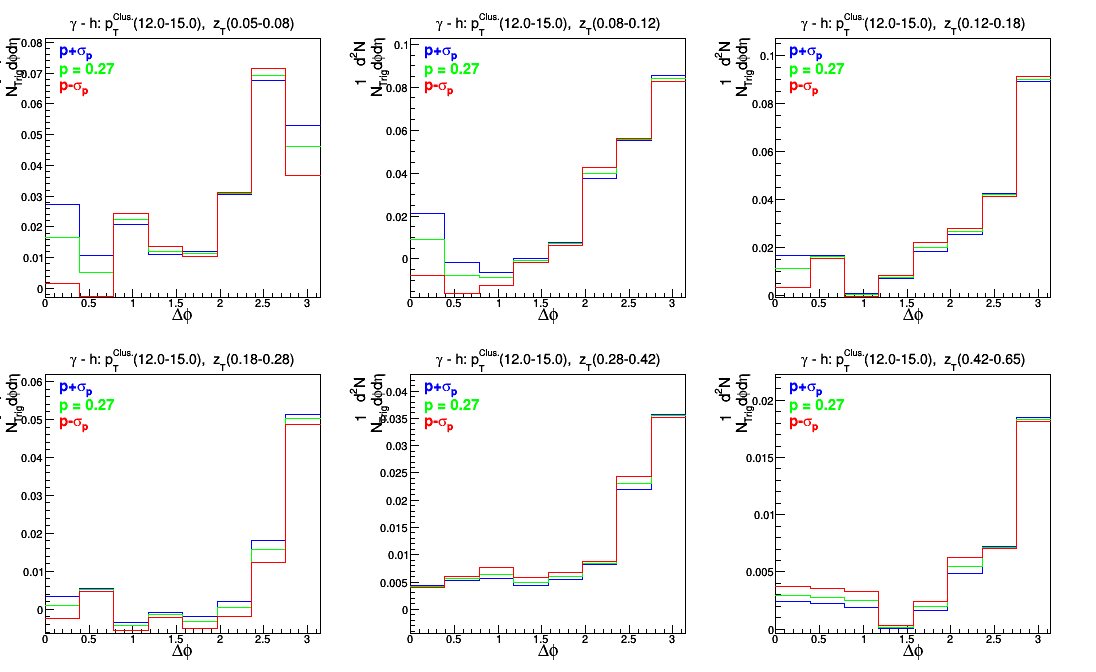

Info in <TCanvas::Print>: pdf file pics/pp_P_Var.pdf has been created


In [41]:
#File2 = 'InputData/13def_4L_SE_L0_Correlation_GMB_Ratio.root'
#File2 = 'InputData/13def_SE_GMB_new_Ratio.root'
#prfx2 = '13def'
File2 = 'InputData/17q_SE_NN_Correlation_GMB_Ratio.root'
#File2 = 'InputData/17q_0GeVTrack_paired_SE_L0_Correlation_GMB_Ratio.root'
prfx2 = 'pp'
FF_P, P_Error = Get_P_Error(File2,prfx2,True,True,True)

# Calculate Efficiency Uncertainty

In [42]:
def Get_Eff_Error(filename,prfx,doZYAM=True, doSubtraction=True, DoSys=False):
    
    latex = TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.05)
    
    Efficiency = 0.85
    Eff_Err = 0.05
    
    Eff_Error = []
    FF_Eff = []
    for ptbin in range(3):
        if (ptbin > 0): continue
        ptbin = ptbin+2
        canvases = ROOT.TCanvas("Canv_Side_Side_%i"%(ptbin),"Canv_Side_Side_%i"%(ptbin),1100,700)
        canvases.Divide(3,2)

        for ztbin in range(6):
            canvases.cd(ztbin+1)
            Signal_min = GetPhiProj(filename,prefix,ptbin,ztbin,True,doZYAM,DoSys) #High DNN (True)
            Background_min = GetPhiProj(filename,prefix,ptbin,ztbin,False,doZYAM,DoSys) #Low DNN (False)
            
            Signal_max = GetPhiProj(filename,prefix,ptbin,ztbin,True,doZYAM,DoSys) #High DNN (True)
            Background_max = GetPhiProj(filename,prefix,ptbin,ztbin,False,doZYAM,DoSys) #Low DNN (False)

            Signal = GetPhiProj(filename,prefix,ptbin,ztbin,True,doZYAM,DoSys) #High DNN (True)
            Background = GetPhiProj(filename,prefix,ptbin,ztbin,False,doZYAM,DoSys) #Low DNN (False)

            N1 = Get_NTriggers(filename,prfx,ptbin, True)
            N2 = Get_NTriggers(filename,prfx,ptbin, False)

            LE_Proj_Sig,legend = GetLEProj(filename, ptbin, ztbin, True)
            LE_Proj_Bkg,legend_bkg = GetLEProj(filename, ptbin, ztbin, False)

            LE_Sig = GetLE_Val(LE_Proj_Sig)
            LE_Bkg = GetLE_Val(LE_Proj_Bkg)

            nbins = Signal.GetSize()-2
        
            #p_error = math.sqrt(0.028**2 + 0.06**2)

            Background_max.Scale((1-purity[ptbin])/purity[ptbin])
            Signal_max.Scale(1/purity[ptbin])
            Signal_max.Add(Background_max,-1)
            Signal_max.Scale(1/(Efficiency+Eff_Err))

            Background_min.Scale((1-purity[ptbin])/purity[ptbin])
            Signal_min.Scale(1/purity[ptbin])
            Signal_min.Add(Background_min,-1) 
            Signal_min.Scale(1/(Efficiency-Eff_Err))

            Background.Scale((1-purity[ptbin])/purity[ptbin])
            Signal.Scale(1/purity[ptbin])
            Signal.Add(Background,-1)
            Signal.Scale(1/Efficiency)
            
            y_min = 1.2*Signal_max.GetMinimum()
            y_max = 1.2*Signal_min.GetMaximum()
            Signal_max.GetYaxis().SetRangeUser(y_min,y_max)
            Signal_max.Draw()
            Signal_min.SetLineColor(2)
            Signal.SetLineColor(3)
            Signal.Draw("same")
            Signal_min.Draw("same")
            
            latex.DrawLatex(0.14,0.85, "#color[4]{Eff+#sigma_{eff}}")
            latex.DrawLatex(0.14,0.79, "#color[3]{Eff}")
            latex.DrawLatex(0.14,0.74, "#color[2]{Eff-#sigma_{eff}}")
            

            #Signal.Add(Signal2,-1)
            
            sum_p_error = 0
            sum_phi = 0
            sum_max = 0
            sum_min = 0
            delta = 0
            for i in range (6,nbins+1):
                sum_phi += Signal.GetBinContent(i)
                delta += (Signal_max.GetBinContent(i)-Signal_min.GetBinContent(i))/2
                sum_min += Signal_min.GetBinContent(i)
                sum_max += Signal_max.GetBinContent(i)

            print abs(delta/sum_phi)
        Eff_Error.append(delta)
        FF_P.append(sum_phi)
        canvases.Update()
        canvases.Draw()
        canvases.SaveAs('pics/%s_Eff_Var.pdf'%(prfx))
    return FF_P,P_Error

0.0590277777778
0.0590277777778
0.0590277777778
0.0590277777778
0.0590277777778
0.0590277777778


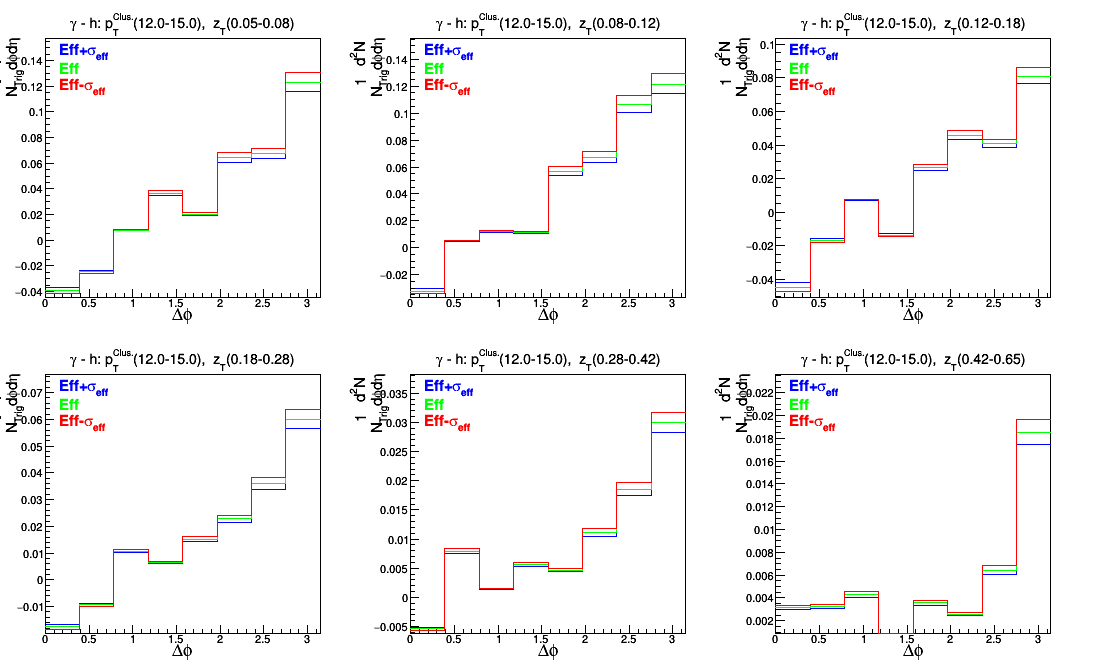

Info in <TCanvas::Print>: pdf file pics/13def_Eff_Var.pdf has been created


In [43]:
#File2 = 'InputData/13def_4L_SE_L0_Correlation_GMB_Ratio.root'
File2 = 'InputData/13def_SE_GMB_new_Ratio.root'
prfx2 = '13def'
#File2 = 'InputData/17q_0GeVTrack_paired_SE_L0_Correlation_GMB_Ratio.root'
#File2 = 'InputData/17q_SE_NN_Correlation_GMB_Ratio.root'
#prfx2 = 'pp'
FF_Eff, Eff_Error = Get_Eff_Error(File2,prfx2,True,True,True)

In [44]:
def Get_Assym_Error(filename,prfx,doZYAM=True, doSubtraction=True, DoSys=False):
    
    File1 = "InputData/13f_SE_Correlation_GMB_Ratio.root"
    File2 = "InputData/13de_4L_SE_Correlation_GMB_Ratio.root"
    
    latex = TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.05)
    
    Efficiency = 0.85
    Eff_Err = 0.05
    
    Eff_Error = []
    FF_Eff = []
    for ptbin in range(3):
        if (ptbin > 0): continue
        ptbin = ptbin+2
        canvases = ROOT.TCanvas("Canv_Side_Side_%i"%(ptbin),"Canv_Side_Side_%i"%(ptbin),1100,700)
        canvases.Divide(3,2)

        for ztbin in range(6):
            canvases.cd(ztbin+1)
            Signal_min = GetPhiProj(File1,prefix,ptbin,ztbin,True,doZYAM,DoSys) #High DNN (True)
            Background_min = GetPhiProj(File1,prefix,ptbin,ztbin,False,doZYAM,DoSys) #Low DNN (False)
            
            Signal_max = GetPhiProj(File2,prefix,ptbin,ztbin,True,doZYAM,DoSys) #High DNN (True)
            Background_max = GetPhiProj(File2,prefix,ptbin,ztbin,False,doZYAM,DoSys) #Low DNN (False)

            Signal = GetPhiProj(filename,prefix,ptbin,ztbin,True,doZYAM,DoSys) #High DNN (True)
            Background = GetPhiProj(filename,prefix,ptbin,ztbin,False,doZYAM,DoSys) #Low DNN (False)

            N1 = Get_NTriggers(filename,prfx,ptbin, True)
            N2 = Get_NTriggers(filename,prfx,ptbin, False)

            LE_Proj_Sig,legend = GetLEProj(filename, ptbin, ztbin, True)
            LE_Proj_Bkg,legend_bkg = GetLEProj(filename, ptbin, ztbin, False)

            LE_Sig = GetLE_Val(LE_Proj_Sig)
            LE_Bkg = GetLE_Val(LE_Proj_Bkg)

            nbins = Signal.GetSize()-2
        

            Background_max.Scale((1-purity[ptbin])/purity[ptbin])
            Signal_max.Scale(1/purity[ptbin])
            Signal_max.Add(Background_max,-1)
            #Signal_max.Scale(1/(Efficiency+Eff_Err))

            Background_min.Scale((1-purity[ptbin])/purity[ptbin])
            Signal_min.Scale(1/purity[ptbin])
            Signal_min.Add(Background_min,-1) 
            #Signal_min.Scale(1/(Efficiency-Eff_Err))

            Background.Scale((1-purity[ptbin])/purity[ptbin])
            Signal.Scale(1/purity[ptbin])
            Signal.Add(Background,-1)
            #Signal.Scale(1/Efficiency)
            
            #y_min = 1.2*Signal_max.GetMinimum()
            #y_max = 1.2*Signal_min.GetMaximum()
            #Signal_max.GetYaxis().SetRangeUser(y_min,y_max)
            Signal_max.Draw()
            Signal_min.SetLineColor(2)
            Signal.SetLineColor(3)
            Signal.Draw("same")
            Signal_min.Draw("same")
            
            latex.DrawLatex(0.14,0.85, "#color[4]{13de}")
            latex.DrawLatex(0.14,0.79, "#color[3]{Eff}")
            latex.DrawLatex(0.14,0.74, "#color[2]{13f}")
            

            #Signal.Add(Signal2,-1)
            
            sum_p_error = 0
            sum_phi = 0
            sum_max = 0
            sum_min = 0
            delta = 0
            for i in range (6,nbins+1):
                sum_phi += Signal.GetBinContent(i)
                delta += (Signal.GetBinContent(i)-Signal_max.GetBinContent(i))/2
                sum_min += Signal_min.GetBinContent(i)
                sum_max += Signal_max.GetBinContent(i)

            print abs(delta/sum_phi)
        P_Error.append(delta)
        FF_P.append(sum_phi)
        canvases.Update()
        canvases.Draw()
        canvases.SaveAs('pics/%s_Assym_Var.pdf'%(prfx))
    return FF_Assym,P_Error

In [45]:
File = 'InputData/13def_4L_SE_L0_Correlation_GMB_Ratio.root'
prfx = '13def'
#File = "InputData/13de_4L_SE_Correlation_GMB_Ratio.root"
#FF_Assym, Eff_Assym = Get_Assym_Error(File,prfx,True,True,True)

In [46]:
print (11/2)

5


# Calculate UE Subtraction Uncertainty

In [47]:
def Subtract_LE2(PhiProjection,LE_Proj,DoSys=False,doMax=True):
    nbins = PhiProjection.GetSize()-2 #underflow,overflow    

    LE_min = (LE_Proj.GetXaxis().FindBin(0.4)) #avoid bias of isolation in this region  
    LE_max = (LE_Proj.GetXaxis().FindBin(1.4))
    LE_N = LE_max-LE_min+1
    LE = LE_Proj.Integral(LE_min,LE_max)/(LE_N)
    
    LE_Error = 0
    for NError in range(LE_min,LE_max):
        LE_Error += (LE_Proj.GetBinError(NError))**2

    LE_Error = math.sqrt(LE_Error)
    LE_Error = LE_Error/(LE_N)
    
    if (doMax):
        LE = LE+LE_Error
    else:
        LE = LE-LE_Error
        
    sumerror=0
    for i in range(nbins+1):
            y = PhiProjection.GetBinContent(i)
            y_error = PhiProjection.GetBinError(i)
            new_y = y-LE
            PhiProjection.SetBinContent(i,new_y)
            if (DoSys):
                #new_y_error = math.sqrt(LE_Error**2) #Propagate the systematic by itself
                new_y_error =  0
            else:
                new_y_error = 0    
            PhiProjection.SetBinError(i,new_y_error)

    #print math.sqrt(sumerror)

In [48]:
def GetPhiProj2(filename,prfx,ipt, izt, Signal_DNN=True, doZYAM=True,DoSys=False,doMax=True):
    file = ROOT.TFile(filename)

    if (DoSys):
        SysE = "_Stat+Sys"
    else:
        SysE = ""
    
    if (Signal_DNN == "inclusive"):
        histo2D = file.Get('Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                        %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        PhiProjection = histo2D.ProjectionX('Inclusive_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f%s' 
                                      %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        100*zTbins[izt+1],SysE),Eta_Axis.FindBin(-0.6),Eta_Axis.FindBin(0.6))
                                        #10*zTbins[izt+1]),5,11)
    
    else:
        DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)
        histo2D = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                            %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        PhiProjection = histo2D.ProjectionX('DNN%i_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f%s' 
                                      %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        100*zTbins[izt+1],SysE),Eta_Axis.FindBin(-0.6),Eta_Axis.FindBin(0.6))
                                        #10*zTbins[izt+1]),5,11)
    
    PhiProjection.SetDirectory(0)
    PhiProjection.Rebin(2)
    PhiProjection.Scale(1.0/1.2) #scale by eta region
    #PhiProjection.SetMarkerStyle(20)
    
    ntriggers = Get_NTriggers(filename,prfx,ipt, Signal_DNN)
    if not(ntriggers == None):
        PhiProjection.Scale(1.0/ntriggers) #per trigger yield
        
        
    Plot1D(PhiProjection,ipt,izt,Signal_DNN)    
    if(doZYAM):
        LE_Proj,legend = GetLEProj(filename, ipt, izt, Signal_DNN)
        Subtract_LE2(PhiProjection,LE_Proj,DoSys,doMax)#Stat+Sys Bool (True, False = Just Stat.)
        #Subtract_ZYAM(PhiProjection)
    
    file.Close()
    return PhiProjection

In [49]:
def Get_LE_Error(filename,prfx,doZYAM=True, doSubtraction=True, DoSys=False):
    
    latex = TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.05)
    
    
    for ptbin in range(3):
        if (ptbin > 0): continue
        ptbin = ptbin+2
        canvases = ROOT.TCanvas("Canv_Side_Side_%i"%(ptbin),"Canv_Side_Side_%i"%(ptbin),1100,700)
        canvases.Divide(3,2)

        LE_Error = []
        FF_LE = []
        for ztbin in range(6):
            canvases.cd(ztbin+1)
            Signal_max = GetPhiProj2(filename,prefix,ptbin,ztbin,True,doZYAM,DoSys,True) #High DNN (True) MAX LE
            Background_max = GetPhiProj2(filename,prefix,ptbin,ztbin,False,doZYAM,DoSys,True) #Low DNN (False) MAX LE
            Signal_min = GetPhiProj2(filename,prefix,ptbin,ztbin,True,doZYAM,DoSys,False) #High DNN (True) MIN LE
            Background_min = GetPhiProj2(filename,prefix,ptbin,ztbin,False,doZYAM,DoSys,False) #Low DNN (False) MIN LE

            Signal = GetPhiProj(filename,prefix,ptbin,ztbin,True,doZYAM,DoSys) #High DNN (True)
            Background = GetPhiProj(filename,prefix,ptbin,ztbin,False,doZYAM,DoSys) #Low DNN (False)

            N1 = Get_NTriggers(filename,prfx,ptbin, True)
            N2 = Get_NTriggers(filename,prfx,ptbin, False)

            LE_Proj_Sig,legend = GetLEProj(filename, ptbin, ztbin, True)
            LE_Proj_Bkg,legend_bkg = GetLEProj(filename, ptbin, ztbin, False)

            LE_Sig = GetLE_Val(LE_Proj_Sig)
            LE_Bkg = GetLE_Val(LE_Proj_Bkg)
                        
            
            nbins = Signal.GetSize()-2
            
            Background_max.Scale((1-purity[ptbin])/purity[ptbin])
            Signal_max.Scale(1/purity[ptbin])
            Signal_max.Add(Background_max,-1)

            Background_min.Scale((1-purity[ptbin])/purity[ptbin])
            Signal_min.Scale(1/purity[ptbin])
            Signal_min.Add(Background_min,-1) 

            Background.Scale((1-purity[ptbin])/purity[ptbin])
            Signal.Scale(1/purity[ptbin])
            Signal.Add(Background,-1)
            
            y_min = 1.2*Signal_max.GetMinimum()
            y_max = 1.2*Signal_min.GetMaximum()
            
            Signal_min.GetYaxis().SetRangeUser(y_min,y_max)
            Signal_min.Draw()
            Signal_min.SetLineColor(2)
            Signal.SetLineColor(3)
            Signal.Draw("same")
            Signal_max.Draw("same")
            
            latex.DrawLatex(0.14,0.85, "#color[4]{LE+#sigma_{LE}}")
            latex.DrawLatex(0.14,0.79, "#color[3]{LE}")
            latex.DrawLatex(0.14,0.74, "#color[2]{LE-#sigma_{LE}}")

            #Signal_min.Add(Signal_max,-1)
            #LE_error = []
            
            sum_phi = 0
            sum_max = 0
            sum_min = 0
            delta = 0
            for i in range (6,nbins+1):
                sum_phi += Signal.GetBinContent(i)
                delta += (Signal_min.GetBinContent(i)-Signal_max.GetBinContent(i))/2
                sum_min += Signal_min.GetBinContent(i)
                sum_max += Signal_max.GetBinContent(i)
            LE_Error.append(delta)
            FF_LE.append(sum_phi)
            print delta/sum_phi
        canvases.Update()
        canvases.Draw()
        canvases.SaveAs('pics/%s_LE_Var.pdf'%(prfx))
    return FF_LE, LE_Error

0.0875977420389
0.0596859454206
0.0801717175784
0.0635966085405
0.0766493586961
0.0561074157205


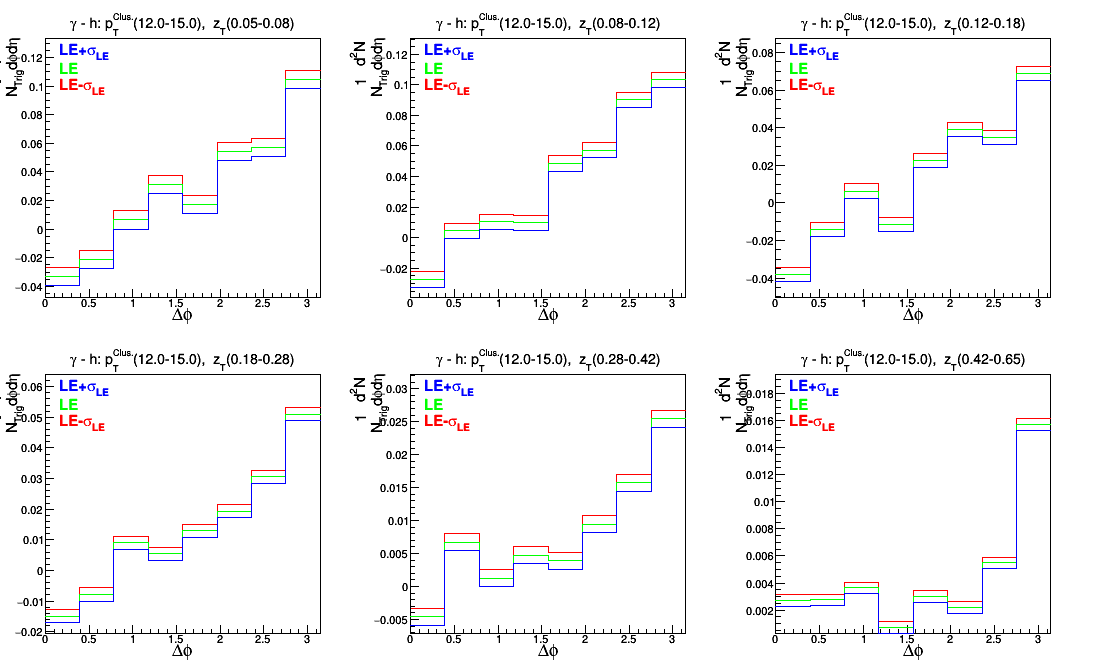

Info in <TCanvas::Print>: pdf file pics/13def_LE_Var.pdf has been created


In [50]:
#File2 = 'InputData/13def_4L_SE_L0_Correlation_GMB_Ratio.root'
File2 = 'InputData/13def_SE_GMB_new_Ratio.root'
prfx2 = '13def'
#File2 = 'InputData/17q_0GeVTrack_paired_SE_L0_Correlation_GMB_Ratio.root'
#File2 = 'InputData/17q_0GeVTrack_paired_SE_L0_Correlation_GMB_Ratio.root'
#File2 = 'InputData/17q_SE_NN_Correlation_GMB_Ratio.root'
#prfx2 = 'pp'
FF_LE,LE_Error=Get_LE_Error(File2,prfx2,True,True,True)

In [51]:
print FF_LE
print FF_P
print FF_Eff

[0.2162687986846052, 0.25090045475199185, 0.14238754633144818, 0.1009565696046069, 0.05058872991047754, 0.02337750837510854]
[0.14620605157645705, 0.1796082514126615, 0.1584839660174834, 0.06640478266500538, 0.06698494542186367, 0.0309972941484592, 0.02750295102953946]
[0.14620605157645705, 0.1796082514126615, 0.1584839660174834, 0.06640478266500538, 0.06698494542186367, 0.0309972941484592, 0.02750295102953946]


# Fragmentation

In [52]:
Systematic = []
for i in range (0,6):
    #LE_E = LE_Err
    Systematic.append(FF_P[i]*math.sqrt(LE_Error[i]**2 + P_Error[i]**2 + Eff_Error[i]**2))
FF_Sys = ROOT.TGraphErrors(n,FF_P,zTbins,1,Systematic);    

NameError: name 'n' is not defined

In [ ]:
zT_point = []
for ztbin in range (6):
    zT_point.append(zTbins[ztbin])
x = np.asarray(zT_point)
dx = 1
#x = np.arange(15, step=dx)
y = np.asarray(FF_LE)
#y = x*2
print x
print y
ex = 0.015#np.ones(x.shape) * dx
ey = y*0.15    # e.g. a 15% uncertainty
matplotlib.pyplot.bar(x, ey, bottom=y-ey/2, width=ex, align='center')
plt.yscale('log')
plt.xscale('log')

# Loop and Plot

In [ ]:
def Looping(filename,DoZYAM,DoSub=True,DoSys=True):
    canvases = []
    subtracts = []
    #newfile = ROOT.TFile("%s_subtracted_correlation.root"%(prefix),"RECREATE")
    #ROOT.gDirectory.pwd()
   
    #File2 = 'InputData/13def_SE_GMB_Ratio.root'
    #File2 = 'InputData/13def_4L_SE_L0_Correlation_GMB_Ratio.root'
    File2 = 'InputData/13def_SE_GMB_new_Ratio.root'
    prfx2 = '13def'
    
    #File2 = 'InputData/17q_SE_Correlation_GMB_Ratio.root'
    #File2 = 'InputData/17q_0GeVTrack_paired_SE_L0_Correlation_GMB_Ratio.root'
    File2 = 'InputData/17q_SE_NN_Correlation_GMB_Ratio.root'
    prfx2 = 'pp'
    
    #File3 = 'InputData/18b10a_calo_pthat1to2_SE_Correlation_GMB_Ratio.root'
    #File3 = 'InputData/18b10a_calo_pthat1to2_SE_Correlation.root'
    File3 = 'InputData/18b10a_pthat_1_2_SE_L0_Correlation_GMB_Ratio.root'
    prfx3 = "18b10a"

    hstack = []
    if (prfx2 == "13def"):
        ymins = [-1.5,-2,-4,-10,-3.5,-3.5]
        ymaxs = [6,5,]
    if (prfx2 == "pp"):
        ymins = [-3,-4,-3,-3,-3.5,-2]
    
    for ptbin in range(3):
        canvases.append(ROOT.TCanvas("canv%i"%(ptbin),"canv",3000,2000))
        canvases[ptbin].Divide(3,2)
        if (ptbin > 0): continue;
        ptbin = ptbin+2
        for ztbin in range(6):
            
            hstack.append(ROOT.THStack("hs_%i"%(ztbin),"#gamma-hadron: p_{T}^{Clus.}(%1.0f-%1.0f) z_{T}(%1.2f-%1.2f)"
                                             %(pTbins[ptbin],pTbins[ptbin+1],zTbins[ztbin],zTbins[ztbin+1])))
            
            hsig3 = GetPhiProj(File3,prfx3,ptbin,ztbin,True,False,True) #[DNN],[Subtraction Bool][DoSys]
            
            #hsig3,hbkg3,NTrig3 = GetBKGsubtracted(File3,prfx3,ptbin,ztbin,DoZYAM,False,True)
            hsig3.SetFillColorAlpha(3,0.15)
            
            hsig,hbkg,NTrig = GetBKGsubtracted(File2,prfx2,ptbin,ztbin,DoZYAM,DoSub,False)#doZYAM,doSubtraction
            hsig_sys,hbkg_sys,NTrig_sys = GetBKGsubtracted(File2,prfx2,ptbin,ztbin,DoZYAM,DoSub,DoSys)
            hsig_sys.SetFillStyle(0);
            hsig_sys.SetLineColor(ROOT.kBlack);
            hsig_sys.SetLineWidth(3);
            #hsig_sys.Draw("E2");

            canvases[ptbin-2].cd(ztbin+1)
            ROOT.gPad.SetLeftMargin(0.18)
            ROOT.gPad.SetRightMargin(0.0)
            
            ymin = ymins[ztbin]*abs(min(hsig.GetMinimum(),hbkg.GetMinimum()))
           
            if (ztbin == 1):
                ymax = 0.5*max(hsig.GetMaximum(),hbkg.GetMaximum())
            else:
                ymax = 0.6*max(hsig.GetMaximum(),hbkg.GetMaximum())
            hsig_sys.GetYaxis().SetRangeUser(ymin,ymax)
            hbkg_sys.GetYaxis().SetRangeUser(ymin,ymax)
            
            if not(DoSub):
                ymax = 1.5*max(hsig.GetMaximum(),hbkg.GetMaximum())
                ymin = -1.5*abs(min(hsig.GetMinimum(),hbkg.GetMinimum()))
                hsig_sys.GetYaxis().SetRangeUser(ymin,ymax)
                hbkg_sys.GetYaxis().SetRangeUser(ymin,ymax)
                hstack[ztbin].Add(hsig)
                
                hstack[ztbin].Add(hsig_sys)
                hstack[ztbin].Add(hbkg)
                hstack[ztbin].Add(hbkg_sys)
                
            else:
                #hsig_sys.GetYaxis().SetRangeUser(-1.8*abs(hsig_sys.GetMinimum()),1.8*hsig_sys.GetMaximum())
                hsig_sys.SetLineColor(1)
                hsig3.SetFillColorAlpha(3,0.2)
                
            
                if (DoSys):
                    hsig_sys.SetFillColor(18)
                    hstack[ztbin].Add(hsig_sys,"E2")
                    #hsig_sys.Draw("sameE2")
                    hstack[ztbin].Add(hsig3,"E3")
            hsig.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{d^{2}N}{d#phid#eta}")
            hstack[ztbin].Add(hsig)
            hstack[ztbin].Draw("nostack")
            hstack[ztbin].GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{d^{2}N}{d#phid#eta}")
            hstack[ztbin].GetYaxis().SetTitleSize(0.05)
            hstack[ztbin].GetYaxis().SetTitleOffset(1.5)
            hstack[ztbin].GetXaxis().SetTitle("#Delta#phi")
            hstack[ztbin].GetXaxis().CenterTitle(1)
            hstack[ztbin].GetXaxis().SetTitleOffset(0.6)
            hstack[ztbin].GetXaxis().SetTitleSize(0.06)
            #hsig.Draw("same")
            
            #hsig3.Draw("sameE3")
            
            latex = TLatex()
            latex.SetNDC()
            latex.SetTextSize(0.04)
            #latex.DrawLatex(0.22,0.81,"#color[3]{pp pythia gamma-jet}")
            
            #Overlay
            if not(DoSub):
                DrawLabel(NTrig,ptbin)
                hbkg.Draw("same")
                canvases[ptbin-2].Update()
                legend = ROOT.TLegend(0.74,0.78,0.89,0.88)
                legend.AddEntry(hsig, "0.55 < DNN < 0.85","p")
                legend.AddEntry(hbkg, "0.0 < DNN < 0.3","p")
                #SetOwnership(legend, 0) # 0 = release (not keep), 1 = keep
                #legend.Draw("same")
                DrawLabel3(NTrig,DoSub)
                
                #show unscaled
                #Bkgd = GetPhiProj(filename,ptbin,ztbin,False,DoZYAM)
                #Bkgd.SetMarkerStyle(21)
                #Bkgd.Draw("same")
        
            else:     
                #draw line at 0
                zero_line = ROOT.TLine(0,0,math.pi,0)
                zero_line.SetLineColorAlpha(2, 0.9)
                zero_line.SetLineWidth(2)
                SetOwnership(zero_line, 0)
                zero_line.Draw("same")
                #DrawLabel3(NTrig,DoSub)
                #ROOT.gDirectory = newfile.GetDirectory()
                #hsig.SetDirectory(newfile)
                #hsig.GetCurrentFile().Write()
                #ROOT.gFile = newfile
                #ROOT.gDirectory = newfile
                #ROOT.gDirectory.pwd()
                #newfile.cd()
                #hsig.Write()
                if (prfx2 == "pp"):
                    latex.DrawLatex(0.22,0.85,"#color[4]{pp After Subtraction}")
                if (prfx2 == "13def"):
                    latex.DrawLatex(0.22,0.85,"#color[4]{p+Pb After Subtraction}")
            #TPave
            
        canvases[ptbin-2].Draw()
  
        if (DoSub): 
            canvases[ptbin-2].SaveAs('pics/%s_Subtracted.pdf'%(prfx2))
            canvases[ptbin-2].SaveAs('pics/%s_Subtracted.png'%(prefix))
        else: 
            canvases[ptbin-2].SaveAs('pics/%s_correlations_Overlay.pdf'%(prfx2))
            canvases[ptbin-2].SaveAs('pics/%s_correlations_Overlay.png'%(prefix))
    #newfile.Close()
    return canvases

In [ ]:
Looping(RootFile,True,True,True)#Filename,DoZYAM,DoSub,!DoSys

# Fragmentation Function

In [ ]:
def FF(File,prfx):
    zT_integral = []
    zT_point = []
    zT_error = []
    
    for ptbin in range(3):
        if (ptbin > 0): continue;
        ptbin = ptbin+2
        
        for ztbin in range(6):
            if (prfx == '18b10a'):
                hsig,hbkg,NTrig = GetBKGsubtracted(File,prfx,ptbin,ztbin,True,False,False)#doZYAM,doSubtraction,dosys 
            else:
                hsig,hbkg,NTrig = GetBKGsubtracted(File,prfx,ptbin,ztbin,True,True,False)#doZYAM,doSubtraction,dosys 
                hsig_sys,hbkg_sys,NTrig_sys = GetBKGsubtracted(File,prfx,ptbin,ztbin,True,True,False)
            Phi_bin_min = hsig.GetXaxis().FindBin(math.pi/2)
            Phi_bin_max = hsig.GetXaxis().FindBin(math.pi) 
            zT_point.append(zTbins[ztbin])
            zT_integral.append(hsig.Integral(hsig.GetXaxis().FindBin(math.pi/2),hsig.GetXaxis().FindBin(math.pi)))
            #zT_integral.append(hsig.Integral((hsig.GetXaxis().FindBin(1.5)),hsig.GetXaxis().FindBin(math.pi)))
            
            #errors
            zt_tmp_e = 0.0
            for phibin in range(Phi_bin_min+1, Phi_bin_max):
                #print phibin
                zt_tmp_e += (hsig.GetBinError(phibin))**2
            
            zT_error.append(math.sqrt(zt_tmp_e))
            #print prfx,": ",zT_integral[ztbin],"+/-",zT_error[ztbin]
            #print "Relative UE",1/(zT_integral[ztbin]/zT_error[ztbin])
            print zT_error[ztbin]/zT_integral[ztbin]
            
    #print zT_error
#     plt.plot(zT_point,zT_integral,'bo')
#     plt.errorbar(zT_point, zT_integral, yerr=zT_error, fmt='s')
#     plt.yscale('log')
#     plt.xscale('log')
#     plt.xlabel('${z_T}$',fontsize=20)
#     plt.title('%s: Integrated $\gamma$-Hadron $2\pi/3 < \Delta\phi < \pi$ '%(prfx))
#     plt.gcf()
#     plt.savefig("pics/%s_FFunction.pdf"%(prfx), bbox_inches='tight')
    #figure.show()
    #plt.figure(num=None, figsize=(12, 8), dpi=100).savefig("pics/%s_FFunction.pdf"%(prefix), bbox_inches='tight')
    #print " "
    return zT_integral,zT_error

In [ ]:
#File2 = 'InputData/17q_0GeVTrack_paired_SE_L0_Correlation_GMB_Ratio.root'
File2 = 'InputData/17q_SE_NN_Correlation_GMB_Ratio.root'
#RootFile = 'InputData/17q_SE_NN_Correlation_GMB_Ratio.root'
prfx2 = 'pp'
#FF(RootFile,"13def")
FF(File2,prfx2)

In [ ]:
#np.geomspace(0.05,1,8)

# Loop All FF

In [ ]:
zT_point = []
for ztbin in range(6):
    zT_point.append(zTbins[ztbin])

#pp_int, pp_error = FF('InputData/17q_SE_Correlation_GMB_Ratio.root','pp')
#pp_int, pp_error = FF('InputData/17q_0GeVTrack_paired_SE_L0_Correlation_GMB_Ratio.root','pp')
pp_int, pp_error = FF('InputData/17q_SE_NN_Correlation_GMB_Ratio.root','pp')
#pPb_int, pPb_error = FF('InputData/13def_SE_GMB_Ratio_Old_Norm.root','13def')
pPb_int, pPb_error = FF('InputData/13def_SE_GMB_new_Ratio.root','13def')
#MC_int, MC_error = FF('InputData/18b10a_calo_pthat1to2_SE_Correlation.root', '18b10a')
MC_int, MC_error = FF('InputData/18b10a_pthat_1_2_SE_L0_Correlation_GMB_Ratio.root', '18b10a')
#MC_int, MC_error = FF('InputData/18b10a_pthat_1_2_0GeVTrack_paired_test_0GeVTracks_Correlation_Lambda_0_to_10.root', '18b10a')
%matplotlib inline
plt.plot(zT_point,pp_int,'bo')
plt.errorbar(zT_point, pp_int, yerr=pp_error, fmt='bs')
plt.plot(zT_point,pPb_int,'ro')
plt.errorbar(zT_point, pPb_int, yerr=pp_error, fmt='rs')
#plt.plot(zT_point,MC_int,'co')
#plt.errorbar(zT_point, MC_int, yerr=pp_error, fmt='cs')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('${z_T}$',fontsize=20)
#plt.figtext(0.7,0.81,"pythia $\gamma$-j",color='Cyan', fontsize=15)
plt.figtext(0.7,0.751,"pPb Data",color='Red', fontsize=15)
plt.figtext(0.7,0.7,"pp Data",color='Blue', fontsize=15)
plt.title('Overlay: Integrated $\gamma$-Hadron $\pi/2 < \Delta\phi < \pi$ ')
plt.gcf()
plt.savefig("pics/All_FFunction.pdf", bbox_inches='tight')
plt.show()


# Overlay MC and Data

In [ ]:
#prefix ='13def'

In [ ]:
def MC_DATA(Region):
        #File1 = 'InputData/17q_0GeVTrack_paired_SE_Correlation_GMB_Ratio.root'
        File1 = 'InputData/17q_SE_Correlation_GMB_Ratio.root'
        prfx1 = 'pp'
        
        File2 = 'InputData/13def_SE_GMB_Ratio_Old_Norm.root'
        prfx2 = '13def'
        File3 = 'InputData/18b10a_calo_pthat1to2_SE_Correlation.root'
        #File3 = 'InputData/18b10a_calo_pthat1to2_SE_Correlation_GMB_Ratio.root'
        prfx3 = "18b10a"
        
        Uncorr = False
        DoZyam = True
        DoSub = True
        DoSys = True
        
        ptbin = 0
        ptbin = ptbin+2;
        canvases = ROOT.TCanvas("Canv_Side_Side_%i"%(ptbin),"Canv_Side_Side_%i"%(ptbin),3500,2500)
        hstack = []
        #canvases = ROOT.TCanvas("Canv_Side_Side_%i"%(ptbin),"Canv_Side_Side_%i"%(ptbin),1000,800)
        
        if (Region=="regions"):
            #canvases.Divide(4,3)
            canvases.Divide(3,2)
        elif(Region=="inclusive"):
            canvases.Divide(3,2)
            
        for ztbin in range(6):
                
            if (Region=="regions"):              
            #grab
                hstack.append(ROOT.THStack("hs_%i"%(ztbin),"#gamma-hadron: p_{T}^{Clus.}(%1.2f-%1.0f) z_{T}(%1.2f-%1.2f)"
                                             %(pTbins[ptbin],pTbins[ptbin+1],zTbins[ztbin],zTbins[ztbin+1])))
                
                hsig3 = GetPhiProj(File3,prfx3,ptbin,ztbin,True,False,False) #[DNN],[Subtraction Bool][DoSys]
                hsig3.SetFillColorAlpha(3,0.15)
                hsig1,htemp,NTrig1 = GetBKGsubtracted(File1,prfx1,ptbin,ztbin,True,False,False)#doZYAM,doSubtraction,dosys 
                hsig1_sys,htemp1,NTrigtemp = GetBKGsubtracted(File1,prfx1,ptbin,ztbin,True,False,False)
                hsig1.SetMarkerColor(6)
                hsig1.SetLineColor(6)
                #hsig1_sys.SetLineColor(1)
                
                hsig2,htemp,NTrig2 = GetBKGsubtracted(File2,prfx2,ptbin,ztbin,True,False,False)#doZYAM,doSubtraction,dosys 
                hsig2_sys,htemp2,NTrigtemp = GetBKGsubtracted(File2,prfx2,ptbin,ztbin,True,False,False)
                hsig2_sys.SetLineColor(1)
                hsig2.SetMarkerColor(1)
                hsig2.SetLineColor(1)
                
                #ymax = 1.2*max(hsig3.GetMaximum(),hsig2.GetMaximum())
                #ymin = -1.4*abs(min(hsig3.GetMinimum(),hsig2.GetMinimum()))
                #hsig1.GetYaxis().SetRangeUser(ymin,ymax)
                #hsig2.GetYaxis().SetRangeUser(ymin,ymax)    
                #canvases.cd(ztbin*2+1)
                
                canvases.cd(ztbin+1)
                ROOT.gPad.SetLeftMargin(0.18)
                ROOT.gPad.SetRightMargin(0.0)
                hstack[ztbin].Add(hsig1)
                hstack[ztbin].Add(hsig2)
                #hstack[ztbin].Add(hsig3,"E3")
                hstack[ztbin].Draw("nostack")
                hstack[ztbin].GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{d^{2}N}{d#phid#eta}")
                hstack[ztbin].GetYaxis().SetTitleSize(0.05)
                hstack[ztbin].GetYaxis().SetTitleOffset(1.5)
                hstack[ztbin].GetXaxis().SetTitle("#Delta#phi")
                hstack[ztbin].GetXaxis().CenterTitle(1)
                hstack[ztbin].GetXaxis().SetTitleOffset(0.6)
                hstack[ztbin].GetXaxis().SetTitleSize(0.06)
                #hstack.Clear()
                Sig_ZYAM= ZYAM_Line(hsig2) #Change to UnCorr_Line, swith to high rapidity
                LE_sig,legend = GetLEProj(File2, ptbin, ztbin,True)
                LE_Line,temp = GetLE_Line(LE_sig)
                #hsig1_sys.Draw("same")
                #hsig1.Draw("same")  
                #DrawLabel2(True)
                
                latex = TLatex()
                latex.SetNDC()
                latex.SetTextSize(0.03)
                latex.DrawLatex(0.2,0.85, "#color[1]{pPb+Pbp UE-Subtracted}")
                latex.DrawLatex(0.2,0.80, "#color[6]{pp UE-Subtracted}")
                #latex.DrawLatex(0.2,0.75, "#color[3]{pp MC: g-jet}")
                
    
            if (Region=="inclusive"):
                    hsig1 = GetPhiProj(RootFile,ptbin,ztbin,"inclusive",False,False)
                    ymax = 1.2*hsig.GetMaximum()
                    hsig1.GetYaxis().SetRangeUser(0,ymax)
                    canvases.cd(ztbin+1) 
                    #hsig1.Draw()  
                    DrawLabel2("inclusive")                  
                
            if (Region=="regions"):
                #hsig2_sys.SetFillColor(19)
                #hsig2_sys.Draw("Same")
                #hsig2.Draw("same")
                #DrawLabel2(False)
                hsig3.SetLineColor(3)
                #hsig3.Draw("same")
            
                
        canvases.Update()
        canvases.Draw()
        if (Region=="inclusive"):
            canvases.SaveAs("pics/%s_Inclusive_Phi_OVERLAY.pdf"%(prefix))
            canvases.SaveAs("pics/%s_Inclusive_Phi_OVERLAY.png"%(prefix))
        if (Region=="regions"):
            if(Uncorr):
                canvases.SaveAs("pics/pp_pPb_UE.pdf")
            else:
                canvases.SaveAs("pics/pp_pPb.pdf")
        return canvases
#myText(.2,.2,"hello_%i"%number,1)

In [ ]:
MC_DATA("regions")

# Divide FF

In [ ]:
def Div_FF(prfx1):
    
    
    if (prfx1 == 'pp'):
        File1 = 'InputData/17q_0GeVTrack_paired_SE_L0_Correlation_GMB_Ratio.root'
        #File1 = 'InputData/17q_0GeVTrack_paired_SE_Correlation_GMB_Ratio.root'
     
    elif (prfx1 == '18b10a'):
        File1 = 'InputData/18b10a_pthat_1_2_SE_L0_Correlation_GMB_Ratio.root'
        
    #File2 = 'InputData/13def_SE_GMB_Ratio.root'
    File2 = 'InputData/13def_4L_SE_L0_Correlation_GMB_Ratio.root'
    prfx2 = '13def'
    
    zT_integral = []
    zT_point = []
    zT_error = []
    
    zT_error_sys = []
   
    for ptbin in range(3):
        if (ptbin > 0): continue;
        ptbin = ptbin+2
        
        for ztbin in range(6):
            #pPb
            hsig,hbkg,NTrig = GetBKGsubtracted(File2,prfx2,ptbin,ztbin,True,True,False)#doZYAM,doSubtraction,dosys 
            hsig_sys,hbkg,NTrig = GetBKGsubtracted(File2,prfx2,ptbin,ztbin,True,True,True)#doZYAM,doSubtraction,dosys 
            Phi_bin_min = hsig.GetXaxis().FindBin(2*math.pi/3)
            Phi_bin_max = hsig.GetXaxis().FindBin(math.pi)-1    
            zT_point.append(zTbins[ztbin])
            pPb_int = hsig.Integral(hsig.GetXaxis().FindBin(2*math.pi/3),hsig.GetXaxis().FindBin(math.pi))
            
            #hsigp = GetPhiProj(File1,prfx1,ptbin,ztbin,True,False,False)
            if (prfx1 == "pp"):
                hsigp,hbkgp,NTrigp = GetBKGsubtracted(File1,prfx1,ptbin,ztbin,True,True,False)#doZYAM,doSubtraction,dosys
                hsigp_sys,hbkgp,NTrigp = GetBKGsubtracted(File1,prfx1,ptbin,ztbin,True,True,True)#doZYAM,doSubtraction,dosys
            else:
                hsigp,hbkgp,NTrigp = GetBKGsubtracted(File1,prfx1,ptbin,ztbin,True,False,True)#doZYAM,doSubtraction,dosys
                hsigp_sys,hbkgp,NTrigp = GetBKGsubtracted(File1,prfx1,ptbin,ztbin,True,False,True)#doZYAM,doSubtraction,dosys
                #hsigp = GetPhiProj(File1,prfx1,ptbin,ztbin,True,False,False)
                #hsigp_sys = GetPhiProj(File1,prfx1,ptbin,ztbin,True,False,True)
            Phi_bin_minp = hsig.GetXaxis().FindBin(2*math.pi/3)
            Phi_bin_maxp = hsig.GetXaxis().FindBin(math.pi)-1   
            #p_int = hsigp.Integral(hsigp.GetXaxis().FindBin(2*math.pi/3),hsigp.GetXaxis().FindBin(math.pi))
            p_int = hsigp.Integral(hsigp.GetXaxis().FindBin(2*math.pi/3),hsigp.GetXaxis().FindBin(math.pi))
            zT_integral.append(pPb_int/p_int)
            
            print "pPb: ",pPb_int
            print "pp: ",p_int
            
            #errors
            zt_tmp_e = 0.0
            zt_tmp_ep = 0.0
            zt_tmp_e_sys = 0.0
            zt_tmp_ep_sys = 0.0
            for phibin in range(Phi_bin_min, Phi_bin_max+1):
                #sum statistical errors for each phi bin in quadrature
                zt_tmp_e += (hsig.GetBinError(phibin))**2
                zt_tmp_ep += (hsigp.GetBinError(phibin))**2
                
                zt_tmp_e_sys += (hsig_sys.GetBinError(phibin))**2
                zt_tmp_ep_sys += (hsigp_sys.GetBinError(phibin))**2
            
            #zt_tmp_e = math.sqrt(zt_tmp_e)
            #zt_tmp_ep= math.sqrt(zt_tmp_ep)
            
            #(sigma_a/Value_a)^2 
            zt_tmp_e = (zt_tmp_e/(pPb_int**2))
            zt_tmp_ep = (zt_tmp_ep/(p_int**2))
            
            zt_tmp_e_sys = (zt_tmp_e_sys/(pPb_int**2))
            zt_tmp_ep_sys = (zt_tmp_ep_sys/(p_int**2))
            
                #zt_tmp_e += (hsig.GetBinError(phibin)/(zT_integral[phibin])**2
                #zt_tmp_ep += (hsigp.GetBinError(phibin)/(zT_integral[phibin]))**2
            #print zT_integral[ztbin]*math.sqrt(zt_tmp_e+zt_tmp_ep)
            
            #print zT_integral[ztbin]
            #print "Quadrature sum, relative Error", (math.sqrt(zt_tmp_e+zt_tmp_ep)/zT_integral[ztbin])
            #print " "
            zT_error.append(zT_integral[ztbin]*math.sqrt(zt_tmp_e+zt_tmp_ep))
            zT_error_sys.append(zT_integral[ztbin]*math.sqrt(zt_tmp_e_sys+zt_tmp_ep_sys))
            #print zT_error[ztbin]
            
            print zT_integral[ztbin],"+/-",zT_error[ztbin]
            #print zT_error_sys[ztbin]
            
    #print zT_error
    plt.plot(zT_point,zT_integral,'bo')
    plt.axhline(y=1, color='r', linestyle='--')
    plt.errorbar(zT_point, zT_integral, yerr=zT_error, fmt='s')
    plt.errorbar(zT_point, zT_integral, yerr=zT_error_sys, color = "Black",fmt='s')
    plt.errorbar(zT_point, zT_integral, yerr=zT_error, color = "Cyan",fmt='s')
    #plt.yscale('log')
    plt.xlabel('${z_T}$',fontsize=20)
    plt.ylabel(r"$\frac{p+Pb}{pp}$",fontsize=20)
    plt.ylim((-1, 3.1)) 
    plt.yticks(np.arange(-1, 3.1, step=0.5))
    plt.xscale('log')
    if (prfx1 == "18b10a"):
        plt.title('pPb/pythia Ratio: Integrated $\gamma$-Hadron $2\pi/3 < \Delta\phi < \pi$ ')
        plt.gcf()
        plt.savefig("pics/MC_pPb_FFunction.pdf", bbox_inches='tight')
    elif(prfx1 == "pp"):
        plt.title('pPb/pp Ratio: Integrated $\gamma$-Hadron $2\pi/3 < \Delta\phi < \pi$ ')
        plt.gcf()
        plt.savefig("pics/pp_pPb_FFunction.pdf", bbox_inches='tight')
    #figure.show()
    plt.show()

In [ ]:
#Div_FF("pp")
Div_FF("18b10a")